In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use("seaborn-v0_8")

In [16]:
import pandas as pd

file_path = '/content/Predicting Energy Consumption.xlsm'
df = pd.read_excel(file_path)
display(df.head())

,Start time UTC,End time UTC,Electricity consumption (MWh)
0,2015-12-31 21:00:00,2015-12-31 22:00:00,10800
1,2015-12-31 22:00:00,2015-12-31 23:00:00,10431
2,2015-12-31 23:00:00,2016-01-01 00:00:00,10005
3,2016-01-01 00:00:00,2016-01-01 01:00:00,9722
4,2016-01-01 01:00:00,2016-01-01 02:00:00,9599


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52966 entries, 0 to 52965
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Start time UTC                 52966 non-null  datetime64[ns]
 1   End time UTC                   52966 non-null  datetime64[ns]
 2   Electricity consumption (MWh)  52966 non-null  int64         
dtypes: datetime64[ns](2), int64(1)
memory usage: 1.2 MB


In [18]:
# renaming the columns for my ease
df.rename(columns={
    "Start time UTC": "datetime",
    "Electricity consumption (MWh)": "consumption"
}, inplace=True)

In [19]:
# concatinating
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
df.set_index('datetime', inplace=True)

# dropping the end time as its not required
df.drop(columns=["End time UTC"], inplace=True)

df.head()

,consumption
datetime,
2015-12-31 21:00:00,10800
2015-12-31 22:00:00,10431
2015-12-31 23:00:00,10005
2016-01-01 00:00:00,9722
2016-01-01 01:00:00,9599


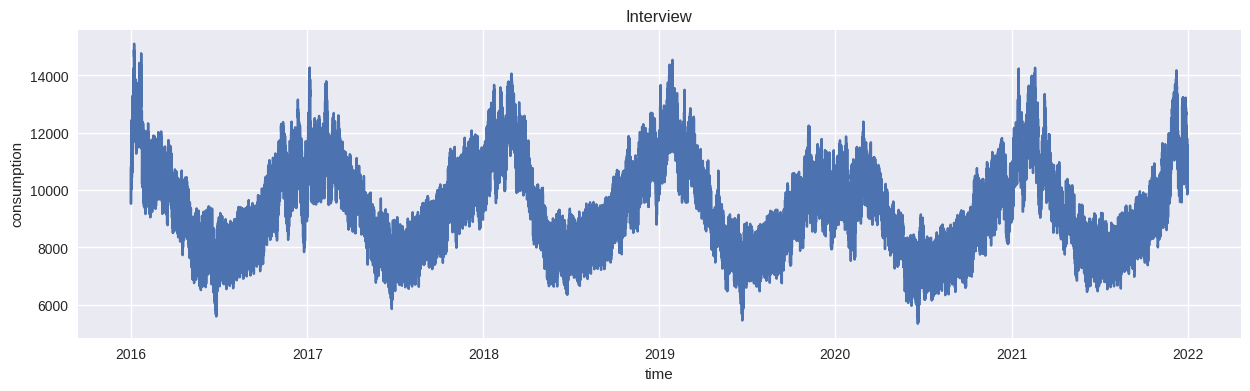

In [22]:
# visualizing
plt.figure(figsize=(15,4))
plt.plot(df.index, df['consumption'])
plt.title("Interview")
plt.xlabel("time")
plt.ylabel("consumption")
plt.show()

In [23]:
# missing values check
df.isnull().sum()

,0
consumption,0


In [24]:
# preprocessing
# 0 null values no need of interpolation (skipped)

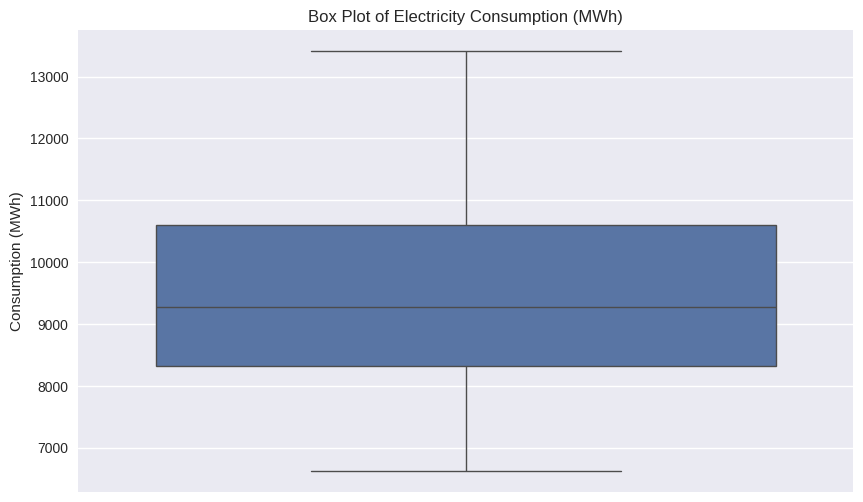

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['consumption'])
plt.title('Box Plot of Electricity Consumption (MWh)')
plt.ylabel('Consumption (MWh)')
plt.show()

In [30]:
# outliers were found so removing them
low = df['consumption'].quantile(0.01)
high = df['consumption'].quantile(0.99)

df['consumption'] = df['consumption'].clip(low, high)

In [32]:
# feture engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

In [33]:
df['lag_1'] = df['consumption'].shift(1)
df['lag_24'] = df['consumption'].shift(24)
df['lag_168'] = df['consumption'].shift(168)

In [34]:
df['rolling_mean_24'] = df['consumption'].rolling(24).mean()
df['rolling_mean_168'] = df['consumption'].rolling(168).mean()

In [36]:
# removing nans of lag
df.dropna(inplace=True)

In [37]:
from sklearn.model_selection import train_test_split

X = df.drop('consumption', axis=1)
y = df['consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# here shuffle was intentionaly kept at false because in time series data, order is important


In [38]:
# trying random forest and xgboost to get the best one
model_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [39]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1,
)

model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [48]:
# evaluating both the models

# here specifically 2 metrics are sed but i also added third metrics just for convinience
# MAE is preferred because it gives a clear, interpretable average error in actual energy units.
# RMSE helps evaluate how well the model handles high-impact errors, especially during peak demand periods.
pred_rf = model_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))

print(f"MAE  : {mae_rf:.2f} MWh")
print(f"RMSE : {rmse_rf:.2f} MWh")

pred_xgb = model_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))

print(f"MAE  : {mae_xgb:.2f} MWh")
print(f"RMSE : {rmse_xgb:.2f} MWh")

MAE  : 82.71 MWh
RMSE : 119.37 MWh
MAE  : 84.65 MWh
RMSE : 122.25 MWh


In [49]:
# I have attached the code for r2 but not useful
# R² is less informative for time-series forecasting because it focuses on variance explained rather than operational accuracy.
from sklearn.metrics import r2_score

r2_rf = r2_score(y_test, pred_rf)
print(f"R2 Score Random Forest: {r2_rf:.4f}")

r2_xgb = r2_score(y_test, pred_xgb)
print(f"R2 Score XGBoost: {r2_xgb:.4f}")

R2 Score Random Forest: 0.9942
R2 Score XGBoost: 0.9939


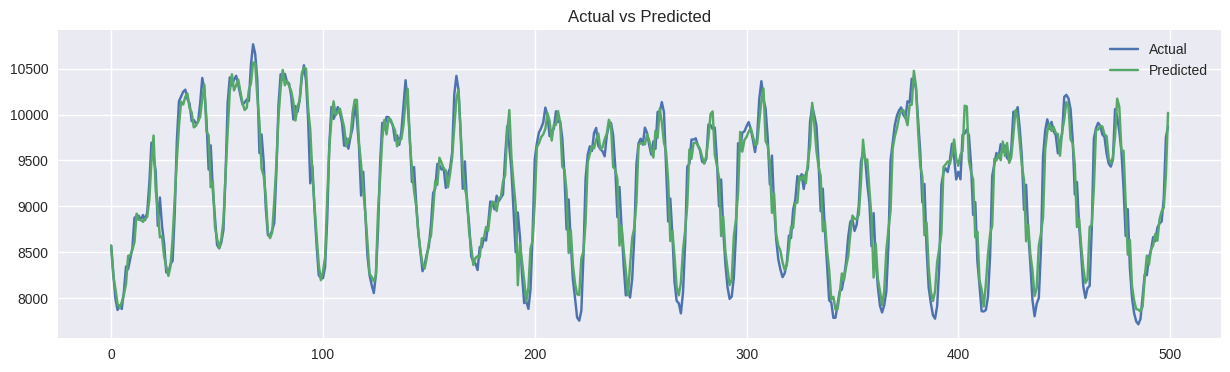

In [42]:
# visualizing random forest prediction

plt.figure(figsize=(15,4))
plt.plot(y_test.values[:500], label="Actual")
plt.plot(pred_rf[:500], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted")
plt.show()

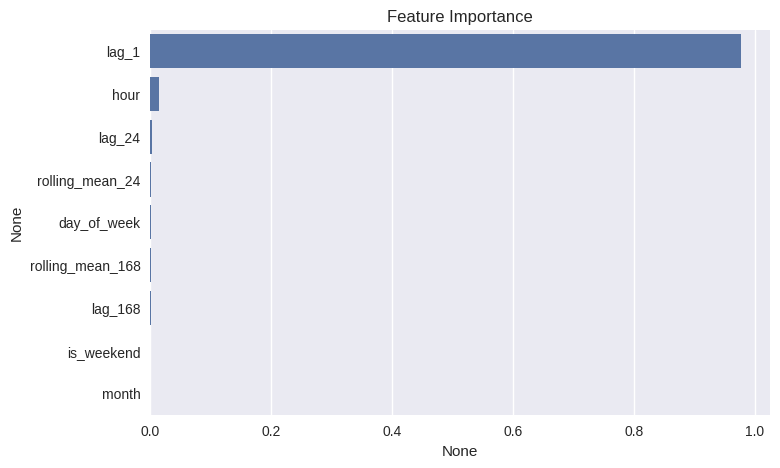

In [45]:
# feature importance
importances = pd.Series(
    model_rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance")
plt.show()

In [47]:
baseline_pred = X_test['lag_24']
baseline_mae = mean_absolute_error(y_test, baseline_pred)

print(f"baseline mae for yesterday but same hour: {baseline_mae:.2f}")

baseline mae for yesterday but same hour: 361.04


In [50]:
# The baseline model predicts electricity consumption using the value from the same hour on the previous day.
# Since the Random Forest model achieves a lower MAE than the baseline, it demonstrates that the model has successfully learned additional temporal patterns beyond simple daily repetition.

**Model Training and Evaluation:**
    *   The data was split into training and testing sets using `train_test_split` with `shuffle=False` to preserve the temporal order, which is critical for time series forecasting.
    *   Two machine learning models were trained:
        Random Forest and XGBoost
        Both the models were evaluted using MAE, RMSE and R2 score